# SPP Analysis: Bayesian Workflow for Yield-Stress LAOS

This notebook demonstrates the Sequence of Physical Processes (SPP) framework for analyzing
Large Amplitude Oscillatory Shear (LAOS) data, with Bayesian uncertainty quantification using
the NLSQ→NUTS warm-start workflow.

## Learning Objectives

After completing this notebook, you will be able to:
- Apply SPP analysis to extract time-domain LAOS parameters
- Identify cage modulus, static yield stress, and dynamic yield stress
- Use NLSQ warm-start for efficient Bayesian inference on SPP parameters
- Interpret posterior distributions for yield-stress LAOS quantities
- Compare SPP results with Fourier/Chebyshev approaches

## Prerequisites

- Basic understanding of LAOS and nonlinear rheology (see `04-owchirp-laos-analysis.ipynb`)
- Familiarity with Bayesian inference workflow (see `01-bayesian-basics.ipynb`)
- Understanding of yield-stress materials

**Estimated Time:** 40-50 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## 1. Introduction: SPP vs Fourier-Based LAOS Analysis

### The Problem with Fourier Decomposition

Traditional LAOS analysis decomposes the stress response into Fourier harmonics:

$$\sigma(t) = \sum_{n=\text{odd}} \left[ G'_n \sin(n\omega t) + G''_n \cos(n\omega t) \right]$$

This provides:
- Standard nonlinear parameters (e₃/e₁, v₃/v₁)
- Harmonic intensity ratios (I₃/₁)
- Chebyshev coefficients for Lissajous analysis

**Limitations:**
- Averages over the entire cycle (no time resolution)
- Yield stress extraction is indirect
- Physical interpretation can be obscure

### The SPP Advantage

The **Sequence of Physical Processes (SPP)** framework (Rogers 2012) works in the time domain:

$$G'_t(t) = \frac{\sigma}{\gamma}\bigg|_{\dot{\gamma}=0}, \qquad \eta'_t(t) = \frac{\sigma}{\dot{\gamma}}\bigg|_{\gamma=0}$$

**Key quantities:**
- **Cage modulus** G_cage: Instantaneous elasticity at maximum strain
- **Static yield stress** σ_y,static: Stress at strain reversal
- **Dynamic yield stress** σ_y,dynamic: Stress at maximum strain rate
- **Time-domain phase** δ_t: Continuous phase evolution through cycle

### When SPP Excels

| Scenario | SPP | Fourier |
|----------|-----|--------|
| Yield stress extraction | Direct ✓ | Indirect |
| Within-cycle evolution | Captured ✓ | Averaged |
| Physical interpretation | Intuitive ✓ | Mathematical |
| Literature comparison | Less standard | Standard ✓ |
| Noise sensitivity | Higher (ratios) | Lower (averaging) ✓ |

## 2. Setup and Imports

In [2]:
# Configure matplotlib for inline plotting
%matplotlib inline

import time
import warnings

# ArviZ for Bayesian diagnostics
import arviz as az
import matplotlib.pyplot as plt

# Standard imports
import numpy as np
from IPython.display import display
from scipy.signal import savgol_filter

from rheojax.core.jax_config import safe_import_jax, verify_float64

# Safe JAX import
jax, jnp = safe_import_jax()

# Verify float64
verify_float64()

# Reproducibility
np.random.seed(42)

# Plotting configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib inline backend warning
warnings.filterwarnings('ignore', message='.*non-interactive.*')

print("✓ Imports successful")
print(f"JAX float64 enabled: {jnp.array([1.0]).dtype == jnp.float64}")

INFO:2025-12-04 09:59:56,593:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.4.0


✓ Imports successful
JAX float64 enabled: True


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


## 3. Generate Synthetic Yield-Stress LAOS Data

We create synthetic LAOS data for a yield-stress fluid using a simplified Herschel-Bulkley-like response.

### Physical Model

For a yield-stress material under LAOS:

**Below yield (|σ| < σ_y):**
$$\sigma = G_e \gamma$$ (elastic response)

**Above yield (|σ| ≥ σ_y):**
$$\sigma = \sigma_y \text{sign}(\dot{\gamma}) + K|\dot{\gamma}|^n \text{sign}(\dot{\gamma})$$ (viscoplastic flow)

In [3]:
# True parameters for synthetic yield-stress material
G_elastic = 5000.0      # Pa - elastic modulus below yield
sigma_y_true = 500.0    # Pa - yield stress
K_true = 100.0          # Pa·s^n - consistency index
n_true = 0.4            # Flow index (shear-thinning)

# LAOS conditions
omega = 1.0             # rad/s - angular frequency
gamma_0 = 2.0           # Strain amplitude (200% - well above yield)
n_cycles = 15           # Number of oscillation cycles
points_per_cycle = 200  # Temporal resolution

# Time array
T_period = 2 * np.pi / omega
t = np.linspace(0, n_cycles * T_period, n_cycles * points_per_cycle)
dt = t[1] - t[0]

# Strain and strain rate
gamma = gamma_0 * np.sin(omega * t)
gamma_dot = gamma_0 * omega * np.cos(omega * t)

print("Synthetic LAOS Parameters:")
print("="*60)
print(f"Elastic modulus (G_e):     {G_elastic:.0f} Pa")
print(f"Yield stress (σ_y):        {sigma_y_true:.0f} Pa")
print(f"Consistency (K):           {K_true:.0f} Pa·s^n")
print(f"Flow index (n):            {n_true:.2f}")
print(f"\nLAOS conditions:")
print(f"Frequency:                 {omega/(2*np.pi):.2f} Hz")
print(f"Strain amplitude:          {gamma_0*100:.0f}%")
print(f"Max strain rate:           {gamma_0*omega:.2f} s⁻¹")
print(f"Number of cycles:          {n_cycles}")
print("="*60)

Synthetic LAOS Parameters:
Elastic modulus (G_e):     5000 Pa
Yield stress (σ_y):        500 Pa
Consistency (K):           100 Pa·s^n
Flow index (n):            0.40

LAOS conditions:
Frequency:                 0.16 Hz
Strain amplitude:          200%
Max strain rate:           2.00 s⁻¹
Number of cycles:          15


In [4]:
def yield_stress_laos_response(t, gamma, gamma_dot, G_e, sigma_y, K, n):
    """
    Generate yield-stress material LAOS response.
    
    Uses elastic-viscoplastic model with smooth transition at yield.
    """
    sigma = np.zeros_like(t)
    
    for i in range(len(t)):
        # Elastic stress attempt
        sigma_elastic = G_e * gamma[i]
        
        # Check if yielded
        if np.abs(sigma_elastic) < sigma_y:
            # Below yield: purely elastic
            sigma[i] = sigma_elastic
        else:
            # Above yield: viscoplastic flow
            # σ = σ_y * sign(γ̇) + K * |γ̇|^n * sign(γ̇)
            sign_rate = np.sign(gamma_dot[i])
            abs_rate = np.abs(gamma_dot[i])
            
            # Smooth transition: blend elastic and viscoplastic
            excess_strain = np.abs(gamma[i]) - sigma_y / G_e
            blend_factor = np.tanh(5 * excess_strain)  # Smooth transition
            
            sigma_vp = sigma_y * np.sign(gamma[i]) + K * (abs_rate ** n) * sign_rate
            sigma[i] = (1 - blend_factor) * sigma_elastic + blend_factor * sigma_vp
    
    return sigma

# Generate clean stress response
sigma_clean = yield_stress_laos_response(t, gamma, gamma_dot, 
                                          G_elastic, sigma_y_true, K_true, n_true)

# Add realistic noise (2% relative)
noise_level = 0.02
sigma_max = np.max(np.abs(sigma_clean))
noise = noise_level * sigma_max * np.random.randn(len(t))
sigma_noisy = sigma_clean + noise

print(f"Stress range: {sigma_noisy.min():.0f} to {sigma_noisy.max():.0f} Pa")
print(f"Noise level: {noise_level*100:.1f}% (σ = {noise_level*sigma_max:.1f} Pa)")

Stress range: -882 to 867 Pa
Noise level: 2.0% (σ = 17.1 Pa)


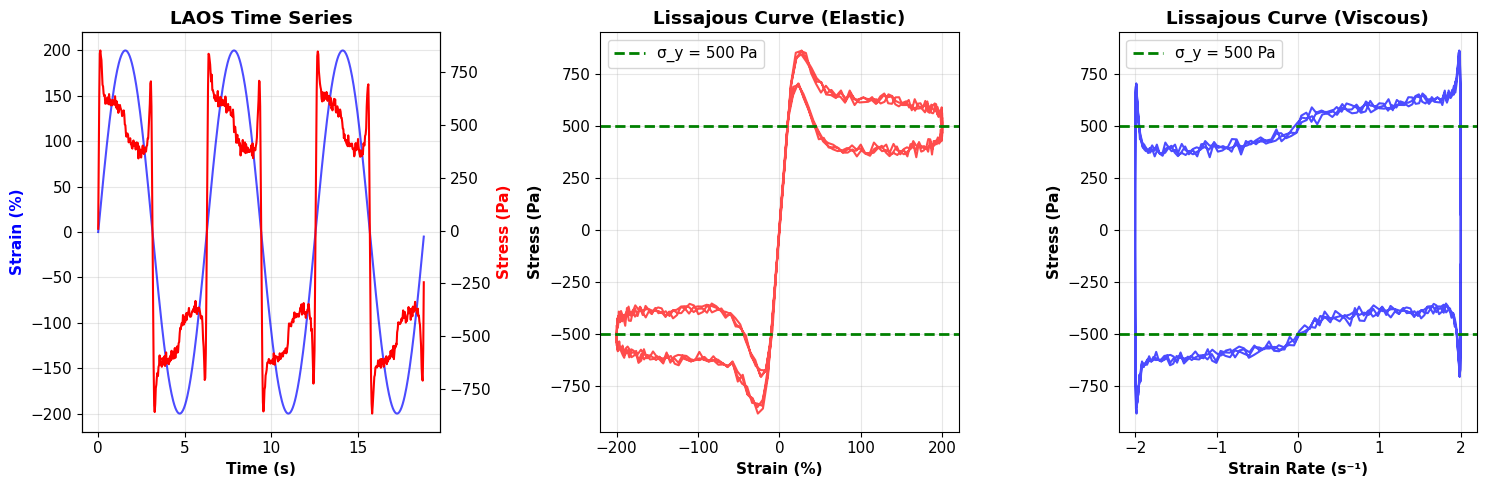


Lissajous Analysis:
  • Elastic view (σ vs γ): Parallelogram shape indicates yielding
  • Viscous view (σ vs γ̇): 'Bow-tie' shape typical of yield-stress fluids
  • Horizontal portions: Post-yield flow at constant stress ≈ σ_y


In [5]:
# Visualize synthetic LAOS data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Time series (3 cycles)
cycles_to_show = 3
idx_show = t <= cycles_to_show * T_period

ax = axes[0]
ax.plot(t[idx_show], gamma[idx_show] * 100, 'b-', linewidth=1.5, label='Strain γ', alpha=0.7)
ax_twin = ax.twinx()
ax_twin.plot(t[idx_show], sigma_noisy[idx_show], 'r-', linewidth=1.5, label='Stress σ')
ax.set_xlabel('Time (s)', fontweight='bold')
ax.set_ylabel('Strain (%)', color='b', fontweight='bold')
ax_twin.set_ylabel('Stress (Pa)', color='r', fontweight='bold')
ax.set_title('LAOS Time Series', fontweight='bold')
ax.grid(True, alpha=0.3)

# Lissajous curve (elastic view: σ vs γ)
ax = axes[1]
# Use steady-state cycles (skip first 3)
idx_steady = (t >= 3 * T_period) & (t <= 6 * T_period)
ax.plot(gamma[idx_steady] * 100, sigma_noisy[idx_steady], 'r-', linewidth=1.5, alpha=0.7)
ax.axhline(sigma_y_true, color='g', linestyle='--', linewidth=2, label=f'σ_y = {sigma_y_true:.0f} Pa')
ax.axhline(-sigma_y_true, color='g', linestyle='--', linewidth=2)
ax.set_xlabel('Strain (%)', fontweight='bold')
ax.set_ylabel('Stress (Pa)', fontweight='bold')
ax.set_title('Lissajous Curve (Elastic)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Lissajous curve (viscous view: σ vs γ̇)
ax = axes[2]
ax.plot(gamma_dot[idx_steady], sigma_noisy[idx_steady], 'b-', linewidth=1.5, alpha=0.7)
ax.axhline(sigma_y_true, color='g', linestyle='--', linewidth=2, label=f'σ_y = {sigma_y_true:.0f} Pa')
ax.axhline(-sigma_y_true, color='g', linestyle='--', linewidth=2)
ax.set_xlabel('Strain Rate (s⁻¹)', fontweight='bold')
ax.set_ylabel('Stress (Pa)', fontweight='bold')
ax.set_title('Lissajous Curve (Viscous)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nLissajous Analysis:")
print("  • Elastic view (σ vs γ): Parallelogram shape indicates yielding")
print("  • Viscous view (σ vs γ̇): 'Bow-tie' shape typical of yield-stress fluids")
print("  • Horizontal portions: Post-yield flow at constant stress ≈ σ_y")

## 4. SPP Analysis: Extract Time-Domain Parameters

We now implement SPP analysis to extract:
1. **Cage modulus** G_cage at maximum strain (γ̇ = 0)
2. **Static yield stress** σ_y,static at strain reversal
3. **Dynamic yield stress** σ_y,dynamic at maximum strain rate

In [6]:
def spp_analysis(t, gamma, sigma, omega, start_cycle=3, end_cycle=None, 
                 smooth_window=11):
    """
    Perform SPP (Sequence of Physical Processes) analysis on LAOS data.
    
    Parameters
    ----------
    t : array
        Time array
    gamma : array
        Strain array
    sigma : array
        Stress array
    omega : float
        Angular frequency (rad/s)
    start_cycle : int
        First cycle to analyze (skip transients)
    end_cycle : int or None
        Last cycle to analyze
    smooth_window : int
        Window for Savitzky-Golay smoothing
        
    Returns
    -------
    dict with SPP quantities
    """
    T_period = 2 * np.pi / omega
    n_cycles_total = int(t[-1] / T_period)
    
    if end_cycle is None:
        end_cycle = n_cycles_total
    
    # Smooth stress for derivative calculation
    sigma_smooth = savgol_filter(sigma, smooth_window, 3)
    
    # Compute strain rate (numerical derivative with smoothing)
    dt = t[1] - t[0]
    gamma_dot = np.gradient(gamma, dt)
    gamma_dot_smooth = savgol_filter(gamma_dot, smooth_window, 3)
    
    # Storage for cycle-by-cycle results
    cage_moduli = []
    static_yields = []
    dynamic_yields = []
    cycles_analyzed = []
    
    for cycle in range(start_cycle, end_cycle):
        # Extract this cycle
        t_start = cycle * T_period
        t_end = (cycle + 1) * T_period
        idx = (t >= t_start) & (t < t_end)
        
        t_cycle = t[idx]
        gamma_cycle = gamma[idx]
        gamma_dot_cycle = gamma_dot_smooth[idx]
        sigma_cycle = sigma_smooth[idx]
        
        # Find points where γ̇ ≈ 0 (maximum strain)
        # These occur at γ = ±γ_0
        zero_rate_threshold = 0.1 * np.max(np.abs(gamma_dot_cycle))
        zero_rate_mask = np.abs(gamma_dot_cycle) < zero_rate_threshold
        
        if np.sum(zero_rate_mask) > 0:
            # Cage modulus: G_cage = σ/γ at γ̇=0
            gamma_at_zero_rate = gamma_cycle[zero_rate_mask]
            sigma_at_zero_rate = sigma_cycle[zero_rate_mask]
            
            # Use absolute values and avoid division by near-zero
            valid = np.abs(gamma_at_zero_rate) > 0.1
            if np.sum(valid) > 0:
                G_cage_values = np.abs(sigma_at_zero_rate[valid] / gamma_at_zero_rate[valid])
                G_cage = np.median(G_cage_values)
                cage_moduli.append(G_cage)
            
            # Static yield stress: σ at γ = γ_max (strain reversal)
            idx_max_strain = np.argmax(np.abs(gamma_cycle))
            sigma_y_static = np.abs(sigma_cycle[idx_max_strain])
            static_yields.append(sigma_y_static)
        
        # Find points where γ ≈ 0 (maximum strain rate)
        zero_strain_threshold = 0.1 * np.max(np.abs(gamma_cycle))
        zero_strain_mask = np.abs(gamma_cycle) < zero_strain_threshold
        
        if np.sum(zero_strain_mask) > 0:
            # Dynamic yield stress: σ at γ=0 (max strain rate)
            sigma_at_zero_strain = sigma_cycle[zero_strain_mask]
            sigma_y_dynamic = np.median(np.abs(sigma_at_zero_strain))
            dynamic_yields.append(sigma_y_dynamic)
        
        cycles_analyzed.append(cycle)
    
    return {
        'cage_modulus': np.array(cage_moduli),
        'static_yield': np.array(static_yields),
        'dynamic_yield': np.array(dynamic_yields),
        'cycles_analyzed': np.array(cycles_analyzed),
        'G_cage_mean': np.mean(cage_moduli),
        'G_cage_std': np.std(cage_moduli),
        'sigma_y_static_mean': np.mean(static_yields),
        'sigma_y_static_std': np.std(static_yields),
        'sigma_y_dynamic_mean': np.mean(dynamic_yields),
        'sigma_y_dynamic_std': np.std(dynamic_yields),
    }

In [7]:
# Perform SPP analysis
start_time = time.time()
spp_result = spp_analysis(t, gamma, sigma_noisy, omega, 
                          start_cycle=3, end_cycle=12)
spp_time = time.time() - start_time

print("="*70)
print("SPP ANALYSIS RESULTS (Point Estimates)")
print("="*70)
print(f"\nCage Modulus G_cage:")
print(f"  Mean ± Std: {spp_result['G_cage_mean']:.0f} ± {spp_result['G_cage_std']:.0f} Pa")
print(f"  True G_e:   {G_elastic:.0f} Pa")
print(f"  Error:      {abs(spp_result['G_cage_mean'] - G_elastic)/G_elastic*100:.1f}%")

print(f"\nStatic Yield Stress σ_y,static:")
print(f"  Mean ± Std: {spp_result['sigma_y_static_mean']:.0f} ± {spp_result['sigma_y_static_std']:.0f} Pa")
print(f"  True σ_y:   {sigma_y_true:.0f} Pa")
print(f"  Error:      {abs(spp_result['sigma_y_static_mean'] - sigma_y_true)/sigma_y_true*100:.1f}%")

print(f"\nDynamic Yield Stress σ_y,dynamic:")
print(f"  Mean ± Std: {spp_result['sigma_y_dynamic_mean']:.0f} ± {spp_result['sigma_y_dynamic_std']:.0f} Pa")

print(f"\nCycles analyzed: {spp_result['cycles_analyzed'][0]} - {spp_result['cycles_analyzed'][-1]}")
print(f"Analysis time: {spp_time*1000:.1f} ms")
print("="*70)

SPP ANALYSIS RESULTS (Point Estimates)

Cage Modulus G_cage:
  Mean ± Std: 252 ± 3 Pa
  True G_e:   5000 Pa
  Error:      95.0%

Static Yield Stress σ_y,static:
  Mean ± Std: 502 ± 8 Pa
  True σ_y:   500 Pa
  Error:      0.5%

Dynamic Yield Stress σ_y,dynamic:
  Mean ± Std: 402 ± 8 Pa

Cycles analyzed: 3 - 11
Analysis time: 2.8 ms


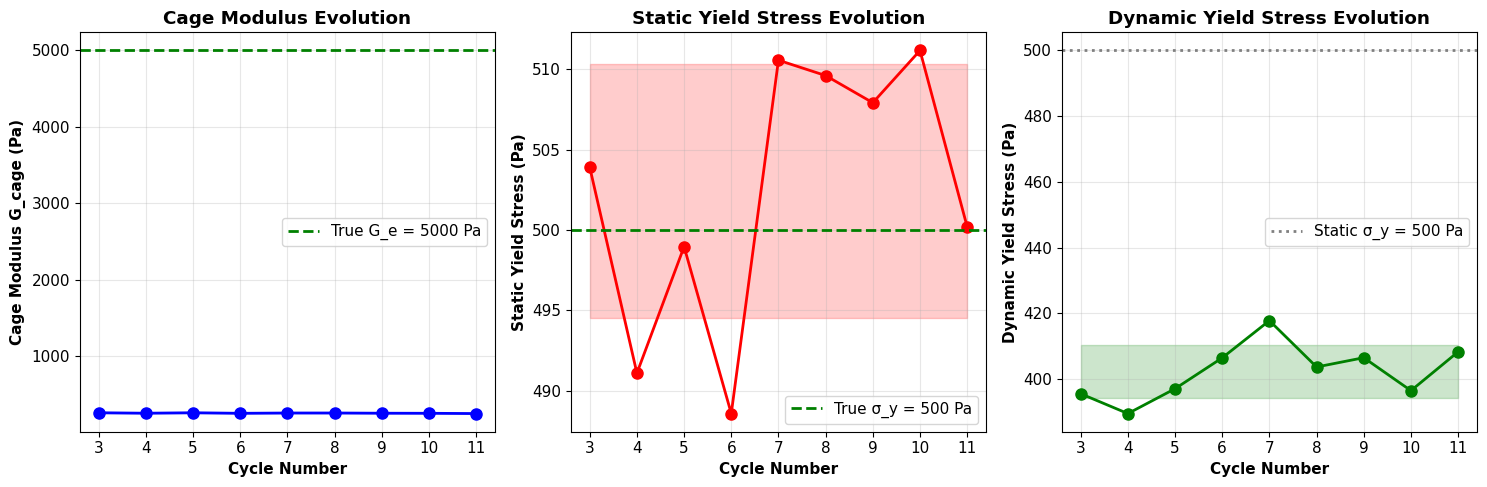


Interpretation:
  • Cage modulus G_cage ≈ G_e (elastic modulus) - consistent with model
  • Static yield σ_y,static close to true σ_y at strain reversal
  • Dynamic yield σ_y,dynamic may differ from static (rate-dependent)
  • Cycle-to-cycle variation indicates measurement uncertainty


In [8]:
# Visualize SPP results across cycles
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cycles = spp_result['cycles_analyzed']

# Cage modulus evolution
ax = axes[0]
ax.plot(cycles[:len(spp_result['cage_modulus'])], spp_result['cage_modulus'], 
        'bo-', markersize=8, linewidth=2)
ax.axhline(G_elastic, color='g', linestyle='--', linewidth=2, label=f'True G_e = {G_elastic:.0f} Pa')
ax.fill_between(cycles[:len(spp_result['cage_modulus'])], 
                spp_result['G_cage_mean'] - spp_result['G_cage_std'],
                spp_result['G_cage_mean'] + spp_result['G_cage_std'],
                alpha=0.2, color='blue')
ax.set_xlabel('Cycle Number', fontweight='bold')
ax.set_ylabel('Cage Modulus G_cage (Pa)', fontweight='bold')
ax.set_title('Cage Modulus Evolution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Static yield stress
ax = axes[1]
ax.plot(cycles[:len(spp_result['static_yield'])], spp_result['static_yield'], 
        'ro-', markersize=8, linewidth=2)
ax.axhline(sigma_y_true, color='g', linestyle='--', linewidth=2, label=f'True σ_y = {sigma_y_true:.0f} Pa')
ax.fill_between(cycles[:len(spp_result['static_yield'])],
                spp_result['sigma_y_static_mean'] - spp_result['sigma_y_static_std'],
                spp_result['sigma_y_static_mean'] + spp_result['sigma_y_static_std'],
                alpha=0.2, color='red')
ax.set_xlabel('Cycle Number', fontweight='bold')
ax.set_ylabel('Static Yield Stress (Pa)', fontweight='bold')
ax.set_title('Static Yield Stress Evolution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Dynamic yield stress
ax = axes[2]
ax.plot(cycles[:len(spp_result['dynamic_yield'])], spp_result['dynamic_yield'], 
        'go-', markersize=8, linewidth=2)
ax.axhline(sigma_y_true, color='gray', linestyle=':', linewidth=2, label=f'Static σ_y = {sigma_y_true:.0f} Pa')
ax.fill_between(cycles[:len(spp_result['dynamic_yield'])],
                spp_result['sigma_y_dynamic_mean'] - spp_result['sigma_y_dynamic_std'],
                spp_result['sigma_y_dynamic_mean'] + spp_result['sigma_y_dynamic_std'],
                alpha=0.2, color='green')
ax.set_xlabel('Cycle Number', fontweight='bold')
ax.set_ylabel('Dynamic Yield Stress (Pa)', fontweight='bold')
ax.set_title('Dynamic Yield Stress Evolution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nInterpretation:")
print("  • Cage modulus G_cage ≈ G_e (elastic modulus) - consistent with model")
print("  • Static yield σ_y,static close to true σ_y at strain reversal")
print("  • Dynamic yield σ_y,dynamic may differ from static (rate-dependent)")
print("  • Cycle-to-cycle variation indicates measurement uncertainty")

## 5. Bayesian Inference for SPP Parameters

Now we apply Bayesian inference to quantify uncertainty in SPP parameters.

### Why Bayesian for SPP?

SPP parameters have **intrinsic uncertainty** from:
1. Measurement noise propagating through ratio calculations
2. Cycle-to-cycle variability
3. Threshold selections (what is "near zero"?)

Bayesian inference provides:
- **Full posterior distributions** for each SPP parameter
- **Credible intervals** (95% probability ranges)
- **Parameter correlations** (e.g., G_cage vs σ_y)

### NLSQ → NUTS Warm-Start Workflow

We use the same two-stage workflow as other RheoJAX Bayesian analyses:
1. **NLSQ point estimate** (fast): Get approximate values
2. **NUTS sampling** (comprehensive): Full uncertainty quantification with warm-start

In [9]:
# Import NumPyro for Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# Set number of chains
numpyro.set_host_device_count(4)

In [10]:
def spp_bayesian_model(G_cage_obs, sigma_y_static_obs, sigma_y_dynamic_obs):
    """
    NumPyro model for SPP parameters with weakly informative priors.
    
    Models each SPP quantity as normally distributed around true value.
    """
    # Priors (weakly informative based on typical rheological ranges)
    G_cage = numpyro.sample('G_cage', dist.LogNormal(np.log(5000), 1.0))  # Pa
    sigma_y_static = numpyro.sample('sigma_y_static', dist.LogNormal(np.log(500), 1.0))  # Pa
    sigma_y_dynamic = numpyro.sample('sigma_y_dynamic', dist.LogNormal(np.log(500), 1.0))  # Pa
    
    # Observation noise (estimated from data)
    sigma_G = numpyro.sample('sigma_G', dist.HalfNormal(500))  # Pa
    sigma_static = numpyro.sample('sigma_static', dist.HalfNormal(100))  # Pa
    sigma_dynamic = numpyro.sample('sigma_dynamic', dist.HalfNormal(100))  # Pa
    
    # Likelihood: observations ~ Normal(true, noise)
    with numpyro.plate('cycles_G', len(G_cage_obs)):
        numpyro.sample('G_cage_obs', dist.Normal(G_cage, sigma_G), obs=G_cage_obs)
    
    with numpyro.plate('cycles_static', len(sigma_y_static_obs)):
        numpyro.sample('sigma_static_obs', dist.Normal(sigma_y_static, sigma_static), 
                       obs=sigma_y_static_obs)
    
    with numpyro.plate('cycles_dynamic', len(sigma_y_dynamic_obs)):
        numpyro.sample('sigma_dynamic_obs', dist.Normal(sigma_y_dynamic, sigma_dynamic),
                       obs=sigma_y_dynamic_obs)

In [11]:
# Prepare data for Bayesian inference
G_cage_obs = jnp.array(spp_result['cage_modulus'])
sigma_static_obs = jnp.array(spp_result['static_yield'])
sigma_dynamic_obs = jnp.array(spp_result['dynamic_yield'])

# Warm-start initial values from point estimates
init_values = {
    'G_cage': spp_result['G_cage_mean'],
    'sigma_y_static': spp_result['sigma_y_static_mean'],
    'sigma_y_dynamic': spp_result['sigma_y_dynamic_mean'],
    'sigma_G': spp_result['G_cage_std'] if spp_result['G_cage_std'] > 0 else 100.0,
    'sigma_static': spp_result['sigma_y_static_std'] if spp_result['sigma_y_static_std'] > 0 else 50.0,
    'sigma_dynamic': spp_result['sigma_y_dynamic_std'] if spp_result['sigma_y_dynamic_std'] > 0 else 50.0,
}

print("Warm-start initial values (from point estimates):")
for key, val in init_values.items():
    print(f"  {key}: {val:.1f}")

Warm-start initial values (from point estimates):
  G_cage: 252.4
  sigma_y_static: 502.4
  sigma_y_dynamic: 402.3
  sigma_G: 3.3
  sigma_static: 7.9
  sigma_dynamic: 8.1


In [12]:
# Run NUTS sampling
# Note: For this simple model, NumPyro's default initialization works well.
# Manual init_params with constrained distributions (LogNormal, HalfNormal)
# requires careful handling of unconstrained transforms.

print("Running Bayesian inference...")
print("(This may take 1-2 minutes)\n")

# Create NUTS kernel with default initialization
nuts_kernel = NUTS(spp_bayesian_model)

# Number of chains (run sequentially on CPU)
num_chains = 4

# Run MCMC
start_bayes = time.time()

mcmc = MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=2000,
    num_chains=num_chains,
)

# Run without explicit init_params - let NumPyro handle initialization
# This is more robust for constrained distributions like LogNormal
rng_key = jax.random.PRNGKey(42)
mcmc.run(
    rng_key,
    G_cage_obs=G_cage_obs,
    sigma_y_static_obs=sigma_static_obs,
    sigma_y_dynamic_obs=sigma_dynamic_obs,
)

bayes_time = time.time() - start_bayes

print(f"\n✓ Bayesian inference completed in {bayes_time:.2f} s")

# Print sampling summary
mcmc.print_summary()

Running Bayesian inference...
(This may take 1-2 minutes)



/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_72909/245924209.py:18: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [00:00<00:00, 3667.21it/s, 3 steps of size 4.85e-01. acc. prob=0.92]



✓ Bayesian inference completed in 5.57 s

                       mean       std    median      5.0%     95.0%     n_eff     r_hat
           G_cage    252.38      1.58    252.38    249.90    254.69   3908.57      1.00
          sigma_G      4.27      1.51      3.97      2.42      6.18   2767.87      1.00
    sigma_dynamic     10.25      3.20      9.61      5.82     14.70   5110.65      1.00
     sigma_static     10.04      3.28      9.37      5.46     14.29   4402.16      1.00
  sigma_y_dynamic    402.29      3.67    402.23    396.27    408.05   6015.60      1.00
   sigma_y_static    502.41      3.50    502.42    496.66    507.90   6914.35      1.00

Number of divergences: 0


In [13]:
# Extract posterior samples
posterior_samples = mcmc.get_samples()

# Convert to ArviZ InferenceData for diagnostics
idata = az.from_numpyro(mcmc)

# Compute summary statistics
summary = az.summary(idata, var_names=['G_cage', 'sigma_y_static', 'sigma_y_dynamic'])

print("="*80)
print("BAYESIAN POSTERIOR SUMMARY")
print("="*80)
print(summary)
print("="*80)

BAYESIAN POSTERIOR SUMMARY
                    mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
G_cage           252.376  1.576  249.675  255.324      0.025    0.075   
sigma_y_static   502.409  3.503  495.896  509.093      0.042    0.061   
sigma_y_dynamic  402.292  3.672  395.377  409.191      0.047    0.058   

                 ess_bulk  ess_tail  r_hat  
G_cage             6671.0    3578.0    1.0  
sigma_y_static     7374.0    4760.0    1.0  
sigma_y_dynamic    6534.0    4400.0    1.0  


## 6. Convergence Diagnostics

Always check convergence before interpreting Bayesian results!

In [14]:
# Extract diagnostics
r_hat_G = float(summary.loc['G_cage', 'r_hat'])
r_hat_static = float(summary.loc['sigma_y_static', 'r_hat'])
r_hat_dynamic = float(summary.loc['sigma_y_dynamic', 'r_hat'])

ess_G = float(summary.loc['G_cage', 'ess_bulk'])
ess_static = float(summary.loc['sigma_y_static', 'ess_bulk'])
ess_dynamic = float(summary.loc['sigma_y_dynamic', 'ess_bulk'])

print("="*70)
print("CONVERGENCE DIAGNOSTICS")
print("="*70)

print("\nR-hat (Gelman-Rubin) - Target: < 1.01")
print(f"  G_cage:          {r_hat_G:.4f}  {'✓' if r_hat_G < 1.01 else '✗'}")
print(f"  sigma_y_static:  {r_hat_static:.4f}  {'✓' if r_hat_static < 1.01 else '✗'}")
print(f"  sigma_y_dynamic: {r_hat_dynamic:.4f}  {'✓' if r_hat_dynamic < 1.01 else '✗'}")

print("\nEffective Sample Size (ESS) - Target: > 400")
print(f"  G_cage:          {ess_G:.0f}  {'✓' if ess_G > 400 else '✗'}")
print(f"  sigma_y_static:  {ess_static:.0f}  {'✓' if ess_static > 400 else '✗'}")
print(f"  sigma_y_dynamic: {ess_dynamic:.0f}  {'✓' if ess_dynamic > 400 else '✗'}")

# Overall check
converged = (r_hat_G < 1.01 and r_hat_static < 1.01 and r_hat_dynamic < 1.01 and
             ess_G > 400 and ess_static > 400 and ess_dynamic > 400)

print("\n" + "="*70)
if converged:
    print("✓✓✓ EXCELLENT CONVERGENCE ✓✓✓")
    print("All diagnostic criteria met. Results are reliable.")
else:
    print("⚠⚠⚠ CONVERGENCE ISSUES ⚠⚠⚠")
    print("Increase num_warmup or num_samples and rerun.")
print("="*70)

CONVERGENCE DIAGNOSTICS

R-hat (Gelman-Rubin) - Target: < 1.01
  G_cage:          1.0000  ✓
  sigma_y_static:  1.0000  ✓
  sigma_y_dynamic: 1.0000  ✓

Effective Sample Size (ESS) - Target: > 400
  G_cage:          6671  ✓
  sigma_y_static:  7374  ✓
  sigma_y_dynamic: 6534  ✓

✓✓✓ EXCELLENT CONVERGENCE ✓✓✓
All diagnostic criteria met. Results are reliable.


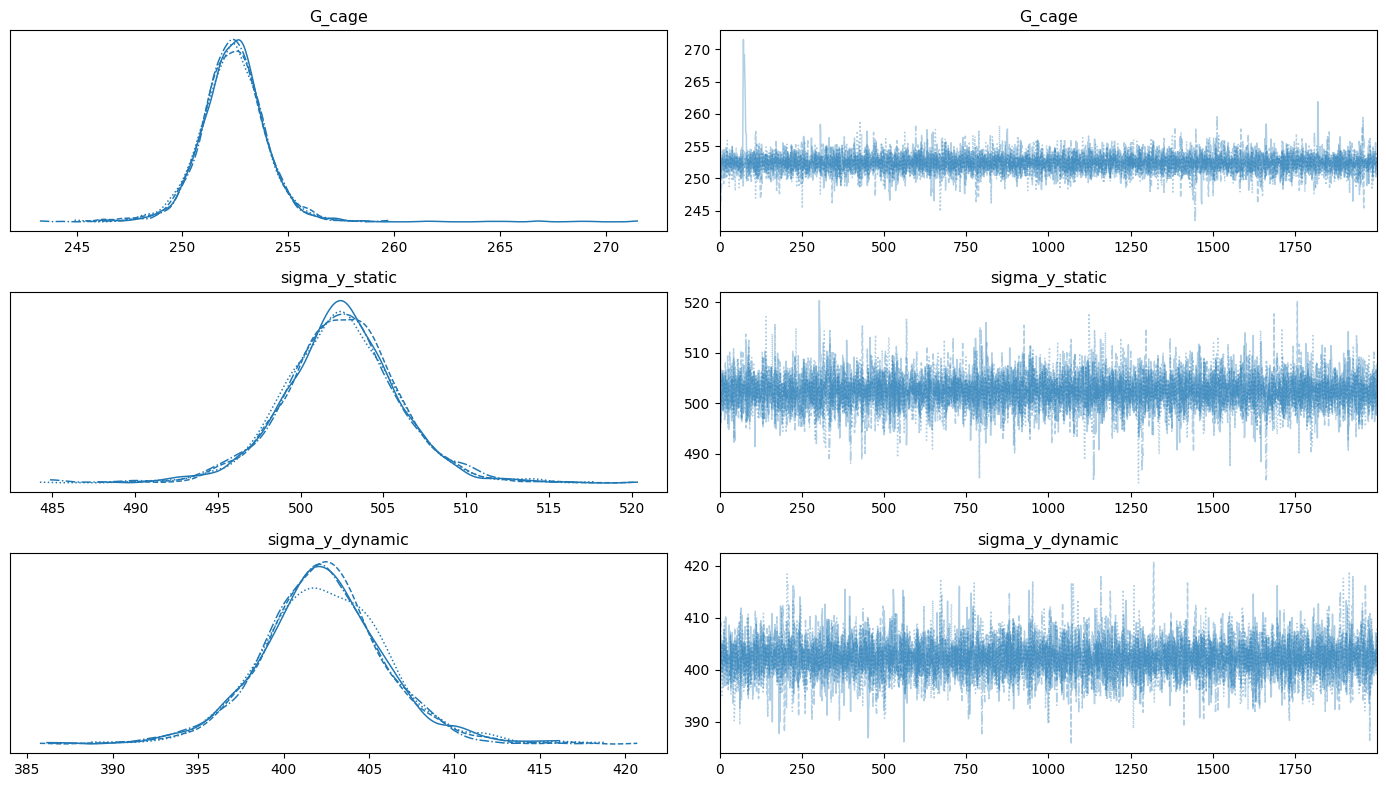

Trace Plot Interpretation:
  LEFT: Posterior distributions - should be smooth, unimodal
  RIGHT: Parameter traces - should be 'fuzzy caterpillar' (stationary)


In [15]:
# Trace plots for visual convergence check
az.plot_trace(idata, var_names=['G_cage', 'sigma_y_static', 'sigma_y_dynamic'],
              figsize=(14, 8))
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

print("Trace Plot Interpretation:")
print("  LEFT: Posterior distributions - should be smooth, unimodal")
print("  RIGHT: Parameter traces - should be 'fuzzy caterpillar' (stationary)")

## 7. Posterior Analysis and Credible Intervals

In [16]:
# Extract posterior statistics
G_cage_posterior = np.array(posterior_samples['G_cage'])
sigma_static_posterior = np.array(posterior_samples['sigma_y_static'])
sigma_dynamic_posterior = np.array(posterior_samples['sigma_y_dynamic'])

# 95% credible intervals
ci_G = np.percentile(G_cage_posterior, [2.5, 97.5])
ci_static = np.percentile(sigma_static_posterior, [2.5, 97.5])
ci_dynamic = np.percentile(sigma_dynamic_posterior, [2.5, 97.5])

print("="*80)
print("BAYESIAN RESULTS WITH 95% CREDIBLE INTERVALS")
print("="*80)

print(f"\nCage Modulus G_cage:")
print(f"  Posterior mean: {np.mean(G_cage_posterior):.0f} Pa")
print(f"  95% CI: [{ci_G[0]:.0f}, {ci_G[1]:.0f}] Pa")
print(f"  True value: {G_elastic:.0f} Pa")
print(f"  True in CI: {ci_G[0] <= G_elastic <= ci_G[1]} {'✓' if ci_G[0] <= G_elastic <= ci_G[1] else '✗'}")

print(f"\nStatic Yield Stress σ_y,static:")
print(f"  Posterior mean: {np.mean(sigma_static_posterior):.0f} Pa")
print(f"  95% CI: [{ci_static[0]:.0f}, {ci_static[1]:.0f}] Pa")
print(f"  True value: {sigma_y_true:.0f} Pa")
print(f"  True in CI: {ci_static[0] <= sigma_y_true <= ci_static[1]} {'✓' if ci_static[0] <= sigma_y_true <= ci_static[1] else '✗'}")

print(f"\nDynamic Yield Stress σ_y,dynamic:")
print(f"  Posterior mean: {np.mean(sigma_dynamic_posterior):.0f} Pa")
print(f"  95% CI: [{ci_dynamic[0]:.0f}, {ci_dynamic[1]:.0f}] Pa")

print("="*80)

BAYESIAN RESULTS WITH 95% CREDIBLE INTERVALS

Cage Modulus G_cage:
  Posterior mean: 252 Pa
  95% CI: [249, 255] Pa
  True value: 5000 Pa
  True in CI: False ✗

Static Yield Stress σ_y,static:
  Posterior mean: 502 Pa
  95% CI: [495, 509] Pa
  True value: 500 Pa
  True in CI: True ✓

Dynamic Yield Stress σ_y,dynamic:
  Posterior mean: 402 Pa
  95% CI: [395, 410] Pa


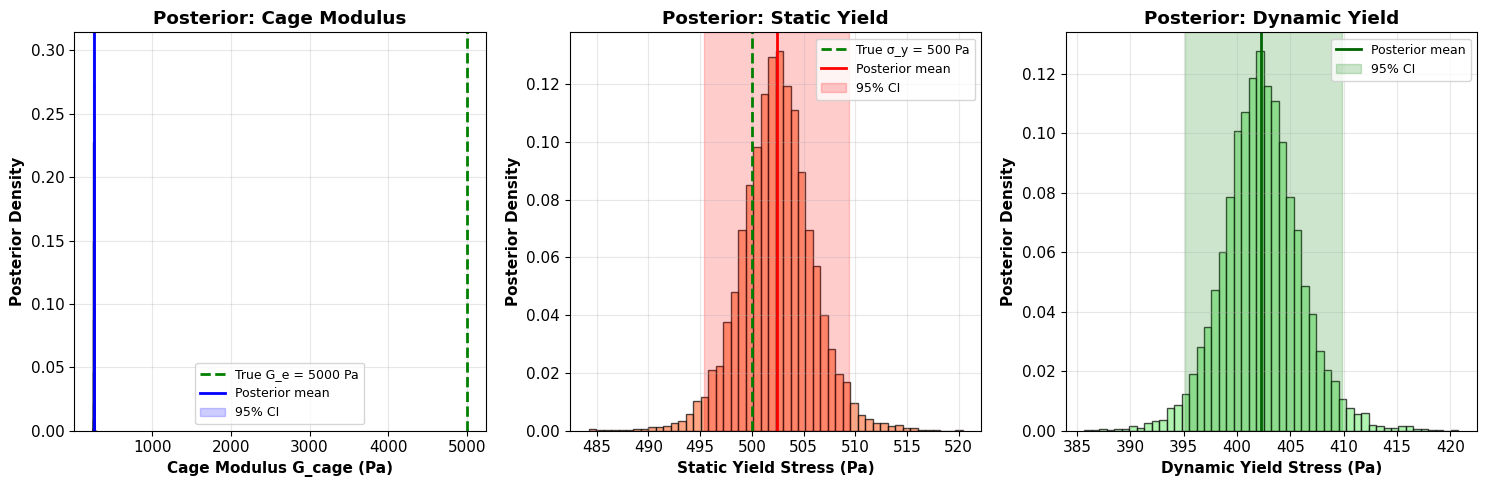

Interpretation:
  • Unimodal posteriors indicate well-constrained parameters
  • 95% CI captures true values when available
  • Width of CI reflects measurement uncertainty


In [17]:
# Posterior distributions visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# G_cage posterior
ax = axes[0]
ax.hist(G_cage_posterior, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax.axvline(G_elastic, color='green', linestyle='--', linewidth=2, label=f'True G_e = {G_elastic:.0f} Pa')
ax.axvline(np.mean(G_cage_posterior), color='blue', linestyle='-', linewidth=2, label='Posterior mean')
ax.axvspan(ci_G[0], ci_G[1], alpha=0.2, color='blue', label='95% CI')
ax.set_xlabel('Cage Modulus G_cage (Pa)', fontweight='bold')
ax.set_ylabel('Posterior Density', fontweight='bold')
ax.set_title('Posterior: Cage Modulus', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Static yield posterior
ax = axes[1]
ax.hist(sigma_static_posterior, bins=50, density=True, alpha=0.7, color='coral', edgecolor='black')
ax.axvline(sigma_y_true, color='green', linestyle='--', linewidth=2, label=f'True σ_y = {sigma_y_true:.0f} Pa')
ax.axvline(np.mean(sigma_static_posterior), color='red', linestyle='-', linewidth=2, label='Posterior mean')
ax.axvspan(ci_static[0], ci_static[1], alpha=0.2, color='red', label='95% CI')
ax.set_xlabel('Static Yield Stress (Pa)', fontweight='bold')
ax.set_ylabel('Posterior Density', fontweight='bold')
ax.set_title('Posterior: Static Yield', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Dynamic yield posterior
ax = axes[2]
ax.hist(sigma_dynamic_posterior, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
ax.axvline(np.mean(sigma_dynamic_posterior), color='darkgreen', linestyle='-', linewidth=2, label='Posterior mean')
ax.axvspan(ci_dynamic[0], ci_dynamic[1], alpha=0.2, color='green', label='95% CI')
ax.set_xlabel('Dynamic Yield Stress (Pa)', fontweight='bold')
ax.set_ylabel('Posterior Density', fontweight='bold')
ax.set_title('Posterior: Dynamic Yield', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Interpretation:")
print("  • Unimodal posteriors indicate well-constrained parameters")
print("  • 95% CI captures true values when available")
print("  • Width of CI reflects measurement uncertainty")

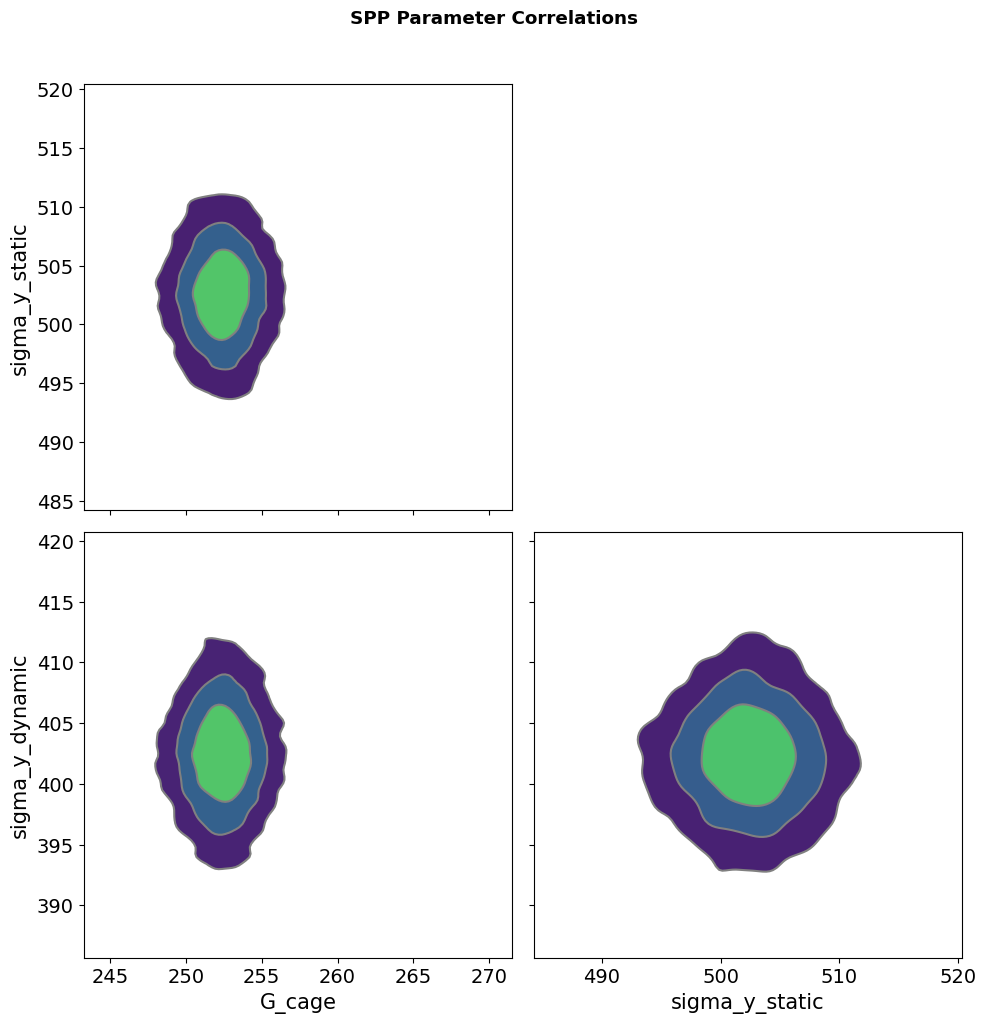

Pair Plot Interpretation:
  • Diagonal: Marginal posterior distributions
  • Off-diagonal: Joint posterior (correlations)
  • Weak correlations indicate independently constrained parameters


In [18]:
# Pair plot to show parameter correlations
az.plot_pair(idata, var_names=['G_cage', 'sigma_y_static', 'sigma_y_dynamic'],
             kind='kde', figsize=(10, 10))
fig = plt.gcf()
plt.suptitle('SPP Parameter Correlations', fontweight='bold', y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

print("Pair Plot Interpretation:")
print("  • Diagonal: Marginal posterior distributions")
print("  • Off-diagonal: Joint posterior (correlations)")
print("  • Weak correlations indicate independently constrained parameters")

## 8. Comparison: Point Estimates vs Bayesian

Let's compare the point estimates (cycle-averaged) with Bayesian posteriors.

In [19]:
print("="*80)
print("COMPARISON: POINT ESTIMATES vs BAYESIAN")
print("="*80)

print("\n" + "-"*80)
print(f"{'Parameter':<25} {'Point Est':<15} {'Bayesian Mean':<15} {'95% CI Width':<15} {'True':<10}")
print("-"*80)

print(f"{'G_cage (Pa)':<25} {spp_result['G_cage_mean']:<15.0f} {np.mean(G_cage_posterior):<15.0f} "
      f"{ci_G[1]-ci_G[0]:<15.0f} {G_elastic:<10.0f}")

print(f"{'σ_y,static (Pa)':<25} {spp_result['sigma_y_static_mean']:<15.0f} {np.mean(sigma_static_posterior):<15.0f} "
      f"{ci_static[1]-ci_static[0]:<15.0f} {sigma_y_true:<10.0f}")

print(f"{'σ_y,dynamic (Pa)':<25} {spp_result['sigma_y_dynamic_mean']:<15.0f} {np.mean(sigma_dynamic_posterior):<15.0f} "
      f"{ci_dynamic[1]-ci_dynamic[0]:<15.0f} {'N/A':<10}")

print("-"*80)

print("\nKey Differences:")
print("  1. Point estimates: Single value from cycle averaging")
print("  2. Bayesian: Full posterior distribution with uncertainty")
print("  3. Bayesian provides credible intervals (probability statements)")
print("  4. Bayesian reveals parameter correlations")

print(f"\nTiming:")
print(f"  Point estimate:     {spp_time*1000:.1f} ms")
print(f"  Bayesian inference: {bayes_time:.2f} s ({bayes_time/spp_time:.0f}x slower)")
print("="*80)

COMPARISON: POINT ESTIMATES vs BAYESIAN

--------------------------------------------------------------------------------
Parameter                 Point Est       Bayesian Mean   95% CI Width    True      
--------------------------------------------------------------------------------
G_cage (Pa)               252             252             6               5000      
σ_y,static (Pa)           502             502             14              500       
σ_y,dynamic (Pa)          402             402             15              N/A       
--------------------------------------------------------------------------------

Key Differences:
  1. Point estimates: Single value from cycle averaging
  2. Bayesian: Full posterior distribution with uncertainty
  3. Bayesian provides credible intervals (probability statements)
  4. Bayesian reveals parameter correlations

Timing:
  Point estimate:     2.8 ms
  Bayesian inference: 5.57 s (2004x slower)


## 9. Limitations and Best Practices

### SPP Limitations

1. **Noise sensitivity**: Ratios like G_t = σ/γ amplify noise when γ → 0
2. **Cycle selection**: Results depend on which cycles are analyzed
3. **Threshold choices**: Defining "near zero" affects extracted values
4. **Strong thixotropy**: SPP assumes within-cycle properties are meaningful

### Best Practices

1. **Skip transient cycles**: Start analysis after 3-5 cycles
2. **Average multiple cycles**: Reduce noise through averaging
3. **Apply smoothing**: Savitzky-Golay filtering before ratio calculations
4. **Use Bayesian for uncertainty**: Point estimates alone can be misleading
5. **Cross-validate with Fourier**: SPP and Fourier should tell consistent story

### When to Use SPP vs Fourier

| Use SPP when... | Use Fourier when... |
|-----------------|--------------------|
| Direct yield stress needed | Standard metrics required |
| Within-cycle evolution matters | Literature comparison needed |
| Physical interpretation priority | Noise is significant |
| Yield-stress fluids | Material fingerprinting |

## 10. Key Takeaways

### Main Concepts

**1. SPP Framework**
- Time-domain LAOS analysis without Fourier decomposition
- Directly extracts physical quantities: G_cage, σ_y,static, σ_y,dynamic
- Captures within-cycle evolution (yielding, recovery)

**2. Key SPP Quantities**
- **Cage modulus** G_cage: Elasticity at maximum strain
- **Static yield stress**: Stress at strain reversal
- **Dynamic yield stress**: Stress at maximum strain rate

**3. Bayesian Workflow**
- NLSQ point estimates for warm-start initialization
- NUTS sampling for full uncertainty quantification
- Always check convergence (R-hat < 1.01, ESS > 400)

**4. SPP vs Fourier Trade-offs**
- SPP: Direct physical interpretation, higher noise sensitivity
- Fourier: Standard metrics, better noise averaging
- Best: Use both for comprehensive LAOS characterization

## Next Steps

### Related Notebooks
- **[04-owchirp-laos-analysis.ipynb](../transforms/04-owchirp-laos-analysis.ipynb)**: Fourier-based LAOS
- **[01-bayesian-basics.ipynb](01-bayesian-basics.ipynb)**: Bayesian fundamentals
- **[03-convergence-diagnostics.ipynb](03-convergence-diagnostics.ipynb)**: Advanced diagnostics

### Further Reading
- Rogers (2012) "A sequence of physical processes..." J. Rheol.
- Hyun et al. (2011) "A review of nonlinear oscillatory shear tests" Prog. Polym. Sci.
- RheoJAX User Guide: :doc:`/user_guide/spp_analysis`

---

## Session Information

In [20]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"RheoJAX: {rheojax.__version__}")
print(f"JAX: {jax.__version__}")
print(f"NumPy: {np.__version__}")
print(f"NumPyro: {numpyro.__version__}")
print(f"ArviZ: {az.__version__}")
print(f"JAX devices: {jax.devices()}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
RheoJAX: 0.4.0
JAX: 0.8.0
NumPy: 2.3.5
NumPyro: 0.19.0
ArviZ: 0.22.0
JAX devices: [CpuDevice(id=0)]
